In [125]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from IPython.display import display
import time 
import tracker
import seaborn as sns
from matplotlib import pyplot as plt
latest_date = tracker.processing_dates[-1]
os.chdir('/mnt/BioAdHoc/Groups/vd-ay/kfetter/hichip-db-loop-calling/')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [126]:
latest_date='2023.10.29.11.48'

In [127]:
# setting input and output with jupyter notebook in context 
if 'ipykernel_launcher.py' in sys.argv[0]:
    input_fn = 'results/samplesheets/hicpro/{}.hicpro.samplesheet.with_header.tsv'.format(latest_date) 
    #split_fastqs = 'results/samplesheets/fastq/{}.fastq.post-check.split_fastqs.with_header.tsv'.format(latest_date)
    hicpro_fn = 'results/samplesheets/fastq/{}.fastq.post-check.run_hicpro'.format(latest_date)
else:
    input_fn = sys.argv[1]
    #split_fastqs = sys.argv[2]
    hicpro_fn = sys.argv[3]

## Helper Functions

In [6]:
def get_log(x, mode='index'):
    
    if mode == 'index':
        logs = glob.glob('results/fastqs/raw/logs/download_srr_fastqs.*-{}'.format(x))
        
    elif mode == 'path':
        info = x.split('/')
        sample_name = info[3]
        srr_id  = info[4].split('.')[0].split('_')[0]
        index = df.loc[(df[0] == sample_name) & (df[3] == srr_id)].iloc[0].name
        logs = glob.glob('results/fastqs/raw/logs/download_srr_fastqs.*-{}'.format(index))
        
    else:
        return('Try again.')
    
    return(logs)

def list_to_str(l, sep=' '):
    l = [str(x) for x in l]
    return(sep.join(l))

In [7]:
def read_hicpro_step2_log(log):
    
    """
    Read the log and extract status information including
    the sample_name, srr_id, status (as indicated by the end message),
    and the download status (as indicate by the "reads written" message).
    """
        
    # initializing the statuses to 0
    hicpro_status = 0
    job_ended = 0
    ice_status = 0

    if os.path.exists(log):
        with open(log, errors='ignore') as fr:
            for line in fr:
                info = line.strip()
                if 'Run ICE Normalization ...' in info:
                    ice_status = 1
                if 'Job Summary Statistics' in info:
                    job_ended = 1
            if ice_status and job_ended:
                hicpro_status = 1
    return(hicpro_status)

In [8]:
def long_to_short_index_list(serial_list):
    
    if len(serial_list) == 0:
        serial_list_short = []
        
    elif len(serial_list) == 1:
        serial_list_short = [str(serial_list[0])]
        
    else:
        small_num = serial_list[0]
        serial_list_short = []
        for i in range(1, len(serial_list)):

            prev_num = serial_list[i -1]
            next_num = serial_list[i]

            if (prev_num + 1) != next_num:

                if small_num == prev_num:
                    curr_range = '{}'.format(small_num)
                    serial_list_short.append(curr_range)
                    small_num = next_num

                else:
                    curr_range = '{}-{}'.format(small_num, prev_num)
                    serial_list_short.append(curr_range)
                    small_num = next_num

        if small_num == next_num:
            curr_range = '{}'.format(small_num,)
            serial_list_short.append(curr_range)
        else:
            curr_range = '{}-{}'.format(small_num, next_num)
            serial_list_short.append(curr_range)

    return(serial_list_short)

## Check HiCPro Main Logs

In [176]:
# load the samplesheet table
df = pd.read_table('results/samplesheets/hicpro/current.mouse.hicpro.samplesheet.without_header.tsv', header=None)
columns = ['std_sample_name', 'gse_id', 'organism', 'bio_rep', 'antibody_target', 'restriction_enzyme', 'sample_name']
df.columns = columns
df['sample_index'] = df.index + 1
df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index
0,3134_siCTRL_1hr_Dex.GSE162617.Mus_Musculus.GR.b1,GSE162617,Mus_Musculus,1,GR,MboI,3134_siCTRL_1hr_Dex,1
1,3134_siNIPBL_1hr_Dex.GSE162617.Mus_Musculus.GR.b1,GSE162617,Mus_Musculus,1,GR,MboI,3134_siNIPBL_1hr_Dex,2
2,3134_WT.GSE162617.Mus_Musculus.GR.b1,GSE162617,Mus_Musculus,1,GR,MboI,3134_WT,3
3,3T3.GSE192387.Mus_Musculus.BATF.b1,GSE192387,Mus_Musculus,1,BATF,MboI,3T3,4
4,3T3.GSE192387.Mus_Musculus.CTCF.b1,GSE192387,Mus_Musculus,1,CTCF,MboI,3T3,5
5,3T3_Irf4.GSE192387.Mus_Musculus.BATF.b1,GSE192387,Mus_Musculus,1,BATF,MboI,3T3_Irf4,6
6,3T3_Irf4_Runx3_Tbet.GSE192387.Mus_Musculus.BAT...,GSE192387,Mus_Musculus,1,BATF,MboI,3T3_Irf4_Runx3_Tbet,7
7,3T3_Norm.GSE178344.Mus_Musculus.SMC1A.b1,GSE178344,Mus_Musculus,1,SMC1A,MboI,3T3_Norm,8
8,3T3_TCF1.GSE178344.Mus_Musculus.SMC1A.b1,GSE178344,Mus_Musculus,1,SMC1A,MboI,3T3_TCF1,9
9,Adult_CTX_SSTcre.GSE150536.Mus_Musculus.H3K27a...,GSE150536,Mus_Musculus,1,H3K27ac,MboI,Adult_CTX_SSTcre,10


In [8]:
log_data = []
for i, sr in df.iterrows():
    
    s1_log = glob.glob('results/hicpro/{}/HiCpro_s1_.e*'.format(sr.std_sample_name))
    s2_log = glob.glob('results/hicpro/{}/HiCpro_s2_.e*'.format(sr.std_sample_name))
    
    # check if s1 steps have started
    if len(s1_log) > 0:
        hicpro_start_status = 1
    else:
        hicpro_start_status = 0
    
    # check if s2 steps have ended 
    if len(s2_log) == 1:
        s2_log = s2_log[0]
        hicpro_end_status = read_hicpro_step2_log(s2_log)
    else:
        hicpro_end_status = 0 
        
    log_data.append([sr.std_sample_name, hicpro_start_status, hicpro_end_status])

log_df = pd.DataFrame(log_data)
log_df.columns = ['std_sample_name', 'hicpro_start_status', 'hicpro_ended_status']

In [9]:
# merge the log information
df = df.merge(log_df, how='left', on=['std_sample_name'], indicator='merge')

In [10]:
df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge
0,293T.GSE128106.Homo_Sapiens.YY1.b1,GSE128106,Homo_Sapiens,1,YY1,HindIII,293T,1,1,1,both
1,293T-PDS.GSE128106.Homo_Sapiens.YY1.b1,GSE128106,Homo_Sapiens,1,YY1,HindIII,293T-PDS,2,1,1,both
2,293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1,GSE128106,Homo_Sapiens,1,YY1,HindIII,293T-TMPYP4,3,1,1,both
3,A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1,GSE133227,Homo_Sapiens,1,CTCF,MboI,A673_SA1m1,4,1,1,both
4,A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b2,GSE133227,Homo_Sapiens,2,CTCF,MboI,A673_SA1m1,5,1,1,both
5,A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b1,GSE133227,Homo_Sapiens,1,CTCF,MboI,A673_SA2m1,6,1,1,both
6,A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b2,GSE133227,Homo_Sapiens,2,CTCF,MboI,A673_SA2m1,7,1,1,both
7,A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b3,GSE133227,Homo_Sapiens,3,CTCF,MboI,A673_SA2m1,8,1,1,both
8,A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b4,GSE133227,Homo_Sapiens,4,CTCF,MboI,A673_SA2m1,9,1,1,both
9,A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b5,GSE133227,Homo_Sapiens,5,CTCF,MboI,A673_SA2m1,10,1,1,both


In [11]:
running = (df.hicpro_start_status == 1) & (df.hicpro_ended_status == 0)
running_df = df.loc[running,:]
print("number of samples running:", len(running_df))

number of samples running: 0


In [12]:
os.chdir('/mnt/bioadhoc-temp/Groups/vd-ay/kfetter/hichip-db-loop-calling/results/fastqs/raw/')
logs = glob.glob('logs/download_srr_fastqs.e*')
flag = 0

for log in logs:
    with open(log, errors='ignore') as fr:
        for line in fr:
            if 'timeout exhausted' in line:
                flag = 1
        if flag == 1:
            print(log)
    flag = 0
    
    

#### add the split data

In [13]:
#split_df = pd.read_table(split_fastqs)
#df = df.merge(split_df[['std_sample_name', 'gse_id', 'split_fastqs_end_status']], on=['std_sample_name', 'gse_id'])

In [14]:
#df

## Identifying problem samples

In [12]:
problems = (df.hicpro_ended_status == 0)
problems_df = df.loc[problems,:]
problems_df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge


## Re-run problematic/ready samples

In [15]:
df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge
0,GM12878.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,Homo_Sapiens,1,H3K27ac,MboI,GM12878,1,1,1,both
1,GM12878.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,Homo_Sapiens,2,H3K27ac,MboI,GM12878,2,1,1,both
2,K562.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,Homo_Sapiens,1,H3K27ac,MboI,K562,3,1,1,both
3,K562.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,Homo_Sapiens,2,H3K27ac,MboI,K562,4,1,1,both
4,K562.GSE101498.Homo_Sapiens.H3K27ac.b3,GSE101498,Homo_Sapiens,3,H3K27ac,MboI,K562,5,1,1,both
5,MyLa.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,Homo_Sapiens,1,H3K27ac,MboI,MyLa,6,1,1,both
6,MyLa.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,Homo_Sapiens,2,H3K27ac,MboI,MyLa,7,1,1,both
7,Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,Homo_Sapiens,1,H3K27ac,MboI,Naive_Tcells,8,1,1,both
8,Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,Homo_Sapiens,2,H3K27ac,MboI,Naive_Tcells,9,1,1,both
9,Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b3,GSE101498,Homo_Sapiens,3,H3K27ac,MboI,Naive_Tcells,10,1,1,both


In [16]:
rerun_df = df.loc[(df.hicpro_start_status == 0)] #df.loc[(df.split_fastqs_end_status == 1) & 
len(rerun_df.sample_index.tolist())

0

In [17]:
# convert not run serial IDs to ranges/short format
rerun_indexes = sorted(rerun_df.sample_index.tolist())
rerun_indexes_sort = long_to_short_index_list(rerun_indexes)

In [18]:
rerun_indexes_sort

[]

In [19]:
# generate a string version of not_run
final_rerun = ','.join(rerun_indexes_sort)
final_rerun = 'qsub -t {} workflow/scripts/hicpro/run_hicpro.qarray.sh'.format(final_rerun)

In [20]:
print(final_rerun)

qsub -t  workflow/scripts/hicpro/run_hicpro.qarray.sh


In [21]:
bash_indexes = ' '.join([str(x) for x in rerun_indexes])
bash_rerun = 'job_ids="{}"\n'.format(bash_indexes)
bash_rerun += 'for i in $job_ids; do bash workflow/scripts/hicpro/run_hicpro.qarray.sh $i; done'

In [22]:
print(bash_rerun)

job_ids=""
for i in $job_ids; do bash workflow/scripts/hicpro/run_hicpro.qarray.sh $i; done


In [23]:
problem_samples = problems_df.std_sample_name.values.tolist()
problem_samples = ' '.join(problem_samples)
problem_samples

''

In [24]:
len(rerun_indexes)

0

# Check HiCPro Statistics Logs for Mapping and Valid Pair Information

        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1_allValidPairs.mergestat
        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1.mpairstat
        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1.mRSsta

In [177]:
#org = "Homo
org = "Mus"

In [178]:
def read_hicpro_stats_log(log):
    log_data = {}
    with open(log) as fr:
        for line in fr:
            if line.startswith('#'):
                continue
            else:
                info = line.strip().split()
                log_data[info[0]] = int(info[1])
    return(log_data)

#### process the mpairstat files

Checked for no broken links
 - hg38 unmerged
 - mm10 unmerged
 
To Check:
 - hg38 merged
 - mm10 merged
 - t2t unmerged
 - t2t merged

In [179]:
all_names = list(df["std_sample_name"])

In [180]:
mpairstat_data = []
found = []
found_but_broken = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mpairstat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    if org in std_sample_name:
        found.append(std_sample_name)
    if org in std_sample_name and "deprecated" not in std_sample_name:
        ac = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mpairstat'.format(std_sample_name = std_sample_name)
        try:
            mpairstat = read_hicpro_stats_log(ac)
            mpairstat['std_sample_name'] = std_sample_name
            mpairstat_data.append(mpairstat)
        except OSError as e:
            sample = str(e).strip().split("/")[2]
            print(sample)
            found_but_broken.append(sample)
mpairstat_df = pd.DataFrame.from_dict(mpairstat_data)

In [181]:
len(found)

194

In [182]:
missing = []
for name in all_names:
    if name not in found:
        missing.append(name)

In [183]:
len(missing)

0

In [184]:
for name in found_but_broken:
    if name not in missing:
        missing.append(name)

In [185]:
len(missing)

0

In [186]:
#missing_df = pd.DataFrame(missing)
#missing_df.to_csv("missing_hicpro_samples_1", header=False, index=False, sep='\t')

In [187]:
mpairstat_df.head()

,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,std_sample_name
0,167324619,34807801,48598619,74570066,0,9348133,0,0,0,74570066,mESC_WT.GSE147919.Mus_Musculus.RYBP.b1
1,132004984,3065941,47936473,70193596,0,10808974,0,0,0,70193596,ES.GSE113339.Mus_Musculus.KLF4.b1
2,495355202,4769264,207747885,232749489,0,50088564,0,0,0,232749489,NOD_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.b2
3,322314473,4947943,89270793,189015444,0,39080293,0,0,0,189015444,mES.GSE80820.Mus_Musculus.Oct4.b2
4,135587854,4009445,33897971,92225592,0,5454846,0,0,0,92225592,mOPC_Ctrl.GSE166177.Mus_Musculus.H3K27ac.b1


In [188]:
len(mpairstat_df)

194

#### process the mRSstat files

In [189]:
mRSstat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mRSstat'
glob_str = tpl.format(std_sample_name='*')
found = []
found_but_broken = []
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    found.append(std_sample_name)
    if org in std_sample_name:
        ac = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mRSstat'.format(std_sample_name = std_sample_name)
        try:
            mRSstat = read_hicpro_stats_log(ac)
            mRSstat['std_sample_name'] = std_sample_name
            mRSstat_data.append(mRSstat)
        except OSError as e:
            sample = str(e).strip().split("/")[2]
            print(sample)
            found_but_broken.append(sample)
mRSstat_df = pd.DataFrame.from_dict(mRSstat_data)

In [190]:
mRSstat_df.head()

,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,std_sample_name
0,66902031,16578104,16580232,16704070,17039625,2748114,4489098,428372,0,0,2451,mESC_WT.GSE147919.Mus_Musculus.RYBP.b1
1,61264370,15130517,15143149,15264825,15725879,4981224,3455857,486547,0,0,5598,ES.GSE113339.Mus_Musculus.KLF4.b1
2,199592339,49618992,49633178,49693161,50647008,25813651,6938174,396100,0,0,9225,NOD_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.b2
3,137934596,33364163,33424120,33782839,37363474,34784621,15132871,1150260,0,0,13096,mES.GSE80820.Mus_Musculus.Oct4.b2
4,58345469,14329452,14349920,14292700,15373397,27377540,6384679,113706,0,0,4198,mOPC_Ctrl.GSE166177.Mus_Musculus.H3K27ac.b1


In [191]:
missing = []
for name in all_names:
    if name not in found:
        missing.append(name)

In [192]:
len(missing)

0

In [193]:
len(mRSstat_df)

194

#### process the mergestat files

In [194]:
mergestat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}_allValidPairs.mergestat'
glob_str = tpl.format(std_sample_name='*')
found = []
found_but_broken = []
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    found.append(std_sample_name)
    if org in std_sample_name:
        ac = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}_allValidPairs.mergestat'.format(std_sample_name = std_sample_name)
        try:
            mergestat = read_hicpro_stats_log(ac)
            mergestat['std_sample_name'] = std_sample_name
            mergestat_data.append(mergestat)
        except OSError as e:
            sample = str(e).strip().split("/")[2]
            print(sample)
            found_but_broken.append(sample)
mergestat_df = pd.DataFrame.from_dict(mergestat_data)

In [195]:
mergestat_df.head()

,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange,std_sample_name
0,66902031,43550932,7310794,36240138,8657494,27582644,mESC_WT.GSE147919.Mus_Musculus.RYBP.b1
1,61264370,56814538,6545303,50269235,13642465,36626770,ES.GSE113339.Mus_Musculus.KLF4.b1
2,199592339,182110256,52406077,129704179,16764719,112939460,NOD_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.b2
3,137934596,94251659,11885470,82366189,21055285,61310904,mES.GSE80820.Mus_Musculus.Oct4.b2
4,58345469,37286994,8101831,29185163,7099719,22085444,mOPC_Ctrl.GSE166177.Mus_Musculus.H3K27ac.b1


In [196]:
len(found)

680

In [197]:
len(found_but_broken)

0

In [198]:
missing = []
for name in all_names:
    if name not in found:
        missing.append(name)

In [199]:
len(missing)

0

In [200]:
len(mergestat_df)

194

#### merge all the stat files together

HiC-Pro performs a couple of quality controls for most of the analysis steps. 

- The alignment statistics are the first quality controls. Aligned reads in the first (end-to-end) step, and alignment after trimming are reported. Note that in pratice, we ususally observed around **10-20% of trimmed reads**. An abnormal level of trimmed reads can reflect a ligation issue. Once the reads are aligned on the genome, HiC-pro checks the number of singleton, multiple hits or duplicates. The fraction of valid pairs are presented for each type of ligation products. Invalid pairs such as dangling and or self-circle are also represented. **A high level of dangling ends, or an imbalance in valid pairs ligation type can be due to a ligation, fill-in or digestion issue**. Finally HiC-Pro also calculated the distribution of fragment size on a subset of valid pairs. Additional statistics will report the fraction of intra/inter-chromosomal contacts, as well as the proportion of short range (<20kb) versus long range (>20kb) contacts.

Source: https://nservant.github.io/HiC-Pro/MANUAL.html

In [201]:
all_stats = mpairstat_df.merge(mRSstat_df, on='std_sample_name').merge(mergestat_df, on='std_sample_name')
# move the std_sample_name to the beginning
tmp = all_stats.pop('std_sample_name')
all_stats.insert(0, 'std_sample_name', tmp)

In [202]:
all_stats = all_stats.sort_values(by='std_sample_name').reset_index(drop=True)

In [203]:
all_stats.describe()

,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
count,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,194.0,1.940000e+02,194.0,194.0,194.0,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,194.0,194.0,194.000000,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02
mean,1.872991e+08,9.898736e+06,5.870492e+07,1.010533e+08,0.0,1.764223e+07,0.0,0.0,0.0,1.010533e+08,7.683126e+07,1.885152e+07,1.886990e+07,1.900696e+07,2.010288e+07,1.799524e+07,5.677791e+06,5.439226e+05,0.0,0.0,5053.000000,7.683126e+07,5.345429e+07,1.189335e+07,4.156094e+07,9.611155e+06,3.194979e+07
std,1.457916e+08,1.534109e+07,5.270426e+07,8.081775e+07,0.0,2.118550e+07,0.0,0.0,0.0,8.081775e+07,6.862598e+07,1.707559e+07,1.709398e+07,1.706217e+07,1.743025e+07,1.928385e+07,5.248874e+06,5.289783e+05,0.0,0.0,5542.385199,6.862598e+07,4.823205e+07,1.615081e+07,3.456833e+07,7.300122e+06,2.857747e+07
min,2.003312e+06,6.604000e+04,7.573870e+05,1.002110e+06,0.0,1.777750e+05,0.0,0.0,0.0,1.002110e+06,7.724370e+05,1.063080e+05,1.070500e+05,1.083460e+05,2.009920e+05,7.786900e+04,7.711400e+04,2.926000e+03,0.0,0.0,45.000000,7.724370e+05,5.863990e+05,6.502200e+04,5.213770e+05,1.822050e+05,1.731950e+05
25%,9.168034e+07,1.439360e+06,2.526451e+07,4.940858e+07,0.0,6.277364e+06,0.0,0.0,0.0,4.940858e+07,3.352128e+07,8.151866e+06,8.157593e+06,8.311876e+06,8.747283e+06,4.411864e+06,1.878657e+06,1.368905e+05,0.0,0.0,1290.250000,3.352128e+07,2.492634e+07,4.209700e+06,1.921978e+07,4.163586e+06,1.395850e+07
50%,1.402473e+08,2.765289e+06,4.169286e+07,7.291069e+07,0.0,1.024256e+07,0.0,0.0,0.0,7.291069e+07,5.533984e+07,1.343681e+07,1.346261e+07,1.369436e+07,1.469169e+07,9.288585e+06,4.062736e+06,4.071750e+05,0.0,0.0,3118.500000,5.533984e+07,3.974516e+07,7.201612e+06,3.194733e+07,7.737158e+06,2.305169e+07
75%,2.451966e+08,8.448552e+06,7.182400e+07,1.289515e+08,0.0,2.060206e+07,0.0,0.0,0.0,1.289515e+08,1.014559e+08,2.493512e+07,2.497812e+07,2.513657e+07,2.571270e+07,2.518737e+07,7.414501e+06,7.600048e+05,0.0,0.0,7709.500000,1.014559e+08,6.715203e+07,1.268889e+07,5.667168e+07,1.363644e+07,4.153249e+07
max,8.717512e+08,8.462131e+07,2.960648e+08,4.705882e+08,0.0,1.447259e+08,0.0,0.0,0.0,4.705882e+08,4.072092e+08,1.016327e+08,1.018016e+08,1.010796e+08,1.026952e+08,1.035901e+08,2.858938e+07,2.893025e+06,0.0,0.0,31747.000000,4.072092e+08,2.694213e+08,1.261978e+08,1.654141e+08,4.631598e+07,1.479930e+08


In [171]:
for x in all_stats.columns.tolist():
    print(x)

std_sample_name
Total_pairs_processed
Unmapped_pairs
Low_qual_pairs
Unique_paired_alignments
Multiple_pairs_alignments
Pairs_with_singleton
Low_qual_singleton
Unique_singleton_alignments
Multiple_singleton_alignments
Reported_pairs
Valid_interaction_pairs
Valid_interaction_pairs_FF
Valid_interaction_pairs_RR
Valid_interaction_pairs_RF
Valid_interaction_pairs_FR
Dangling_end_pairs
Religation_pairs
Self_Cycle_pairs
Single-end_pairs
Filtered_pairs
Dumped_pairs
valid_interaction
valid_interaction_rmdup
trans_interaction
cis_interaction
cis_shortRange
cis_longRange


In [204]:
final_df = all_stats.sort_values(by='std_sample_name').reset_index(drop=True)

In [205]:
final_df

,std_sample_name,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
0,3134_WT.GSE162617.Mus_Musculus.GR.b1,60977251,6898810,22951058,27079918,0,4047465,0,0,0,27079918,25637471,6402728,6402161,6402385,6430197,1040209,302456,99283,0,0,499,25637471,6328792,1887196,4441596,674834,3766762
1,3134_siCTRL_1hr_Dex.GSE162617.Mus_Musculus.GR.b1,95173343,12477817,29616862,46338115,0,6740549,0,0,0,46338115,41120637,10239658,10221141,10220824,10439014,3935295,1040933,240022,0,0,1228,41120637,5856741,970338,4886403,925173,3961230
2,3134_siNIPBL_1hr_Dex.GSE162617.Mus_Musculus.GR.b1,61528277,8246941,20452257,28859725,0,3969354,0,0,0,28859725,26626041,6655687,6638129,6601440,6730785,1568083,528684,135644,0,0,1273,26626041,4837155,870343,3966812,861690,3105122
3,3T3.GSE192387.Mus_Musculus.BATF.b1,254054774,2521198,101400856,129545646,0,20587074,0,0,0,129545646,104904556,25758461,25788788,25665436,27691871,14846030,9230100,533213,0,0,31747,104904556,76759465,11218989,65540476,16710650,48829826
4,3T3.GSE192387.Mus_Musculus.CTCF.b1,318884253,2751035,127178884,165439898,0,23514436,0,0,0,165439898,140970470,34649866,34687565,34367884,37265155,12310754,11503466,640180,0,0,15028,140970470,99071049,12266813,86804236,21272554,65531682
5,3T3_Irf4.GSE192387.Mus_Musculus.BATF.b1,227232360,1486556,83351976,127168979,0,15224849,0,0,0,127168979,101819415,24959097,24964763,24860462,27035093,16357521,8316742,670016,0,0,5285,101819415,66652903,9913270,56739633,13526546,43213087
6,3T3_Irf4_Runx3_Tbet.GSE192387.Mus_Musculus.BAT...,226938707,2155687,88693437,118057145,0,18032438,0,0,0,118057145,94683578,23206985,23189724,23012917,25273952,12854566,9735038,754011,0,0,29952,94683578,69794796,9288339,60506457,17538476,42967981
7,3T3_Norm.GSE178344.Mus_Musculus.SMC1A.b1,524441382,6428956,225956359,232990220,0,59065847,0,0,0,232990220,206077769,51342351,51338493,51292154,52104771,20167729,5721843,1014682,0,0,8197,206077769,155432246,35273162,120159084,22815848,97343236
8,3T3_TCF1.GSE178344.Mus_Musculus.SMC1A.b1,552100726,7237252,217819284,271195356,0,55848834,0,0,0,271195356,215144683,53301311,53347376,53384489,55111507,44007827,11128864,906525,0,0,7457,215144683,194949432,41656551,153292881,30199691,123093190
9,AML12_shCtrl.GSE141113.Mus_Musculus.H3K9me3.b1,259862568,35624879,80848607,115058066,0,28331016,0,0,0,115058066,102005218,25429742,25429224,25412601,25733651,10674526,2017307,358545,0,0,2470,102005218,30069273,6029741,24039532,4080838,19958694


In [206]:
final_df.to_excel("tables/hicpro_mm10_unmerged.xlsx")

/mnt/BioAdHoc/Groups/vd-ay/kfetter/packages/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total_pairs_processed', ylabel='Density'>

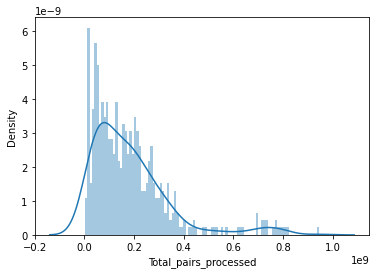

In [27]:
sns.distplot(all_stats.Total_pairs_processed, bins=100)

In [28]:
all_stats.sort_values("Valid_interaction_pairs")

,std_sample_name,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
2,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,368198300,40070235,98502332,145231169,0,84394564,0,0,0,145231169,142311693,35422814,35442431,34888857,36557591,384661,2439391,91596,0,0,3828,142311693,24451343,7252188,17199155,3582488,13616667
1,Aortic-VIC.GSE154513.Homo_Sapiens.H3K27ac.b1,691966559,89629145,134802884,426947089,0,40587441,0,0,0,426947089,151539207,36967672,36938322,36803979,40829234,241900199,32375777,1113269,0,0,18637,151539207,49418834,10112944,39305890,9912856,29393034
4,Middle-Frontal-Gyrus.GSE147672.Homo_Sapiens.H3...,342871082,12061532,125277389,185823950,0,19708211,0,0,0,185823950,159804042,39548249,39617888,39304044,41333861,14287717,10349453,1363018,0,0,19720,159804042,40330465,7445322,32885143,8565118,24320025
5,Retina.GSE196235.Homo_Sapiens.H3K27ac.b2,363619558,4818446,137436990,200894985,0,20469137,0,0,0,200894985,175154636,43356446,43360655,43414314,45023221,15646874,8889701,1192304,0,0,11470,175154636,163371935,40416380,122955555,27368032,95587523
0,AoSMC.GSE178598.Homo_Sapiens.H3K27ac.b1,337307006,1885728,95143433,217445106,0,22832739,0,0,0,217445106,191374595,47102056,47175625,47299152,49797762,12190069,11319043,2555023,0,0,6376,191374595,102208315,12987863,89220452,27316972,61903480
3,HCC1599-WT.GSE116872.Homo_Sapiens.SMC1A.b1,769438941,3970351,290252923,431002534,0,44213133,0,0,0,431002534,405941395,101111076,101136708,101245780,102447831,17169784,6218621,1656613,0,0,16121,405941395,364785134,125746494,239038640,32043205,206995435


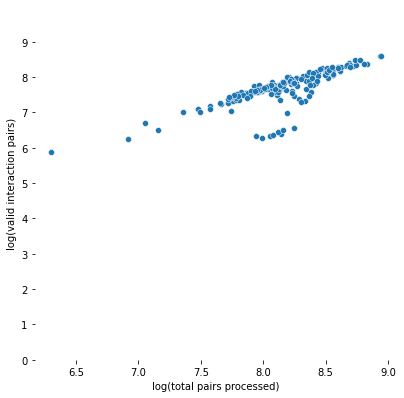

In [24]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=np.log10(all_stats["Total_pairs_processed"]),
                y=np.log10(all_stats["Valid_interaction_pairs"]),
                ax=ax)
ax.set_xlabel('log(total pairs processed)')
ax.set_ylabel('log(valid interaction pairs)')
ax.set_ylim(0, 10)
ax.set_yticks(range(0, 10))

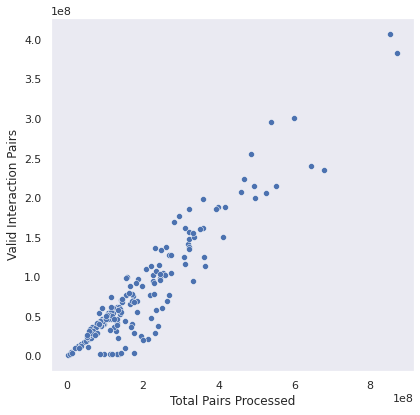

In [27]:
sns.set_theme(style="dark")
f, ax = plt.subplots(figsize=(6.5, 6.5))
#sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="Total_pairs_processed",
                y="Valid_interaction_pairs",
                data=all_stats, ax=ax, palette="pastel")
ax.set_xlabel('Total Pairs Processed')
ax.set_ylabel('Valid Interaction Pairs')
fig = ax.get_figure()
fig.savefig('mouse-valid-interact.png', dpi=300)

In [12]:
sns.displot(data=all_stats, x='Valid_interaction_pairs', bins=100)

NameError: name 'all_stats' is not defined

## Checking Kyra's Samples

In [36]:
ss = '/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/results/samplesheets/fastq/2022.04.09.16.57.fastq.samplesheet.with_header.tsv'

In [37]:
kf_data

NameError: name 'kf_data' is not defined

In [ ]:
kf_data = pd.read_table(ss)

In [ ]:
null_hic_samples = kf_data.iloc[[0,1,2,3,18,19]]

In [ ]:
null_hic_samples

In [ ]:
sparse_samples = kf_data.iloc[range(5,19)]

In [ ]:
sparse_samples

In [ ]:
all_stats.loc[all_stats.std_sample_name.isin(null_hic_samples.std_sample_name)]

In [ ]:
null_hic_samples.std_sample_name.tolist()

In [ ]:
all_stats

In [ ]:
hic_ss = '/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/results/samplesheets/hicpro/2022.04.09.16.57.hicpro.samplesheet.with_header.tsv'

In [ ]:
hic_ss_df = pd.read_table(hic_ss)

In [ ]:
hic_ss_df